# Homework 4: Modeling Text Data

### Team Member 1:
* UNI: ba2500
* Name: Baran Akyol

### Team Member 2 [optional]:
* UNI:  
* Name:


You can find the data here: https://data.boston.gov/dataset/vision-zero-entry

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
import itertools
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MaxAbsScaler, Normalizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from gensim import models
import gensim

# Task1 - Data Cleaning  [10 points]

Load the data, visualize the class distribution. Clean up the target labels. Some categories have been arbitrarily split and need to be consolidated. 

In [3]:
def import_data(filename):
    """imports the data from as csv and removes duplicates and N/A values
    
    Parameters
    ----------
    
    filename: str
    
    Path to or filename of object
    
    Returns
    -------
    
    data: pandas DataFrame object
    
    """
    #import data
    data = pd.read_csv(filename)
    
    #remove duplicates
    data = data.drop_duplicates('COMMENTS')
    
    #remove the remaining empty cell
    data = data[data['COMMENTS'].notnull()]
    
    return data
 

In [4]:
def clean_labels(data):
    
    #dictionary with replacement key/value pairs
    replacedict = {'REQUESTTYPE' : { 
    "there's not enough time to cross the street" : "no time to cross St." ,
    "people are not given enough time to cross the street":"no time to cross St.",
    'people have to wait too long for the "Walk" signal' : 'Wait is too long',
    'the wait for the "Walk" signal is too long': 'Wait is too long',
    "bike facilities don't exist or need improvement" : 'insufficient Bike facilities',
    'there are no bike facilities or they need maintenance': 'insufficient Bike facilities',
    "sidewalks/ramps don't exist or need improvement" : 'insufficient sidewalks',
    'there are no sidewalks or they need maintenance': 'insufficient sidewalks',   
    "it's too far / too many lanes to cross" : 'too many lanes to cross',
    'people have to cross too many lanes / too far': 'too many lanes to cross',
    'it\xe2\x80\x99s hard for people to see each other' : "Can't see/low visibility",
    'it is hard to see / low visibility': 'low visibility', #check
    'the roadway surface needs improvement':'roadway  needs improvement',
    'it\xe2\x80\x99s hard to see / low visibility': "Can't see/low visibility",
'" src="images/02 - Wait is too long.png"></span>&nbsp;the wait for the "Walk" signal is too long':'Wait is too long',
'" src="images/06 - Speeding.png"></span>&nbsp;people speed':'people speed',
'" src="images/10 - Hard to see.png"></span>&nbsp;it\xe2\x80\x99s hard to see / low visibility':"Can't see/low visibility",
'" src="images/11 - Sidewalk issue.png"></span>&nbsp;sidewalks/ramps don\'t exist or need improvement': 'insufficient sidewalks',
'" src="images/12 - Bike facility issue.png"></span>&nbsp;the roadway surface needs improvement':'roadway  needs improvement',
        'the roadway surface needs maintenance' : 'roadway  needs improvement',
'" src="images/14 - Other issue.png"></span>&nbsp;of something that is not listed here': 'other complaints',
        'of something that is not listed here':'other complaints',
        "people don't yield while going straight":'No yield straight',
        "people don't yield while turning": "No yield turning",
        "people cross away from the crosswalks" : "People Jaywalk",
'" src="images/01 - Not enough time to cross.png"></span>&nbsp;there\'s not enough time to cross the street': "no time to cross St."
        } }
    
    return data.replace(replacedict)
    

In [5]:
def plot_class(data):
        
    label,count = np.unique(data['REQUESTTYPE'],return_counts=1)
    sortedlabel = sorted(zip(label,count),key=itemgetter(1))

    label,count = zip(*sortedlabel)
    plt.barh(np.arange(len(label)),count)
    plt.yticks(np.arange(len(label))+0.5,label)
    plt.show()
    pass

In [6]:
def cv_score(alg,X,y,cv=3,Return=False):
    
    """Computes cv score
    
    parameters
    ----------
    
    alg: The algorithm to use
    
    """
    
    score = cross_val_score(alg,X,y,cv=cv,scoring='f1_macro')
    print 'scores : ', score
    print 'mean : ', np.mean(score)
    
    if Return:
        return np.mean(score)
    else:
        pass
    

In [7]:
def f1(model,X,y):
    prediction = model.predict(X)
    return f1_score(y,prediction,average= 'macro')

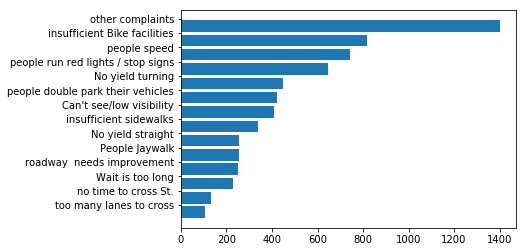

In [9]:
plot_class(clean_labels(import_data('Vision_Zero_Entry.csv')))

# Task2 - Model 1 [10 points]

Run a baseline multi-class classification model using a bag-of-word approach, report macro f1-score (should be above .5) and visualize the confusion matrix. Can you interpret the mistakes made by the model? 

In [10]:
def generate_train_test(filename,seed=0):
    
    foo = import_data(filename)
    bar = clean_labels(foo)
    
    X_train, X_test, y_train, y_test = train_test_split( bar['COMMENTS'], bar['REQUESTTYPE'],\
                                                    random_state = seed, stratify = bar['REQUESTTYPE'] )
    
    return X_train,X_test,y_train,y_test


#runing it
X_train, X_test, y_train, y_test = generate_train_test('Vision_Zero_Entry.csv',seed=4995)


In [11]:
# dictionary for GridSearch
parameters = {
    'countvectorizer__max_df': (0.25, 0.5, 0.75, 1.0),
    'countvectorizer__max_features': (3000,5000,10000),
    'tfidftransformer__use_idf': (True, False),
    'tfidftransformer__norm': ('l1', 'l2'),
    'logisticregressioncv__Cs': (1,20,30,40),
    'logisticregression__penalty': ('l1','l2'),
    'logisticregression__fit_intercept': (True,False),
    'logisticregression__solver':('newton-cg','lbfgs','sag')
}

#pipeline
model1_pipe = make_pipeline(CountVectorizer(),TfidfTransformer(),
            LogisticRegressionCV(Cs=20,class_weight='balanced', multi_class='multinomial',solver='lbfgs'))
model1_pipe.fit(X_train,y_train)


Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,...    random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0))])

In [12]:
#cv_score(model1_pipe,X_train,y_train,cv=5)

"""
scores :  [ 0.53  0.57  0.53  0.54  0.55]
mean :  0.543814570022
"""

assert f1(model1_pipe,X_test,y_test) > 0.54

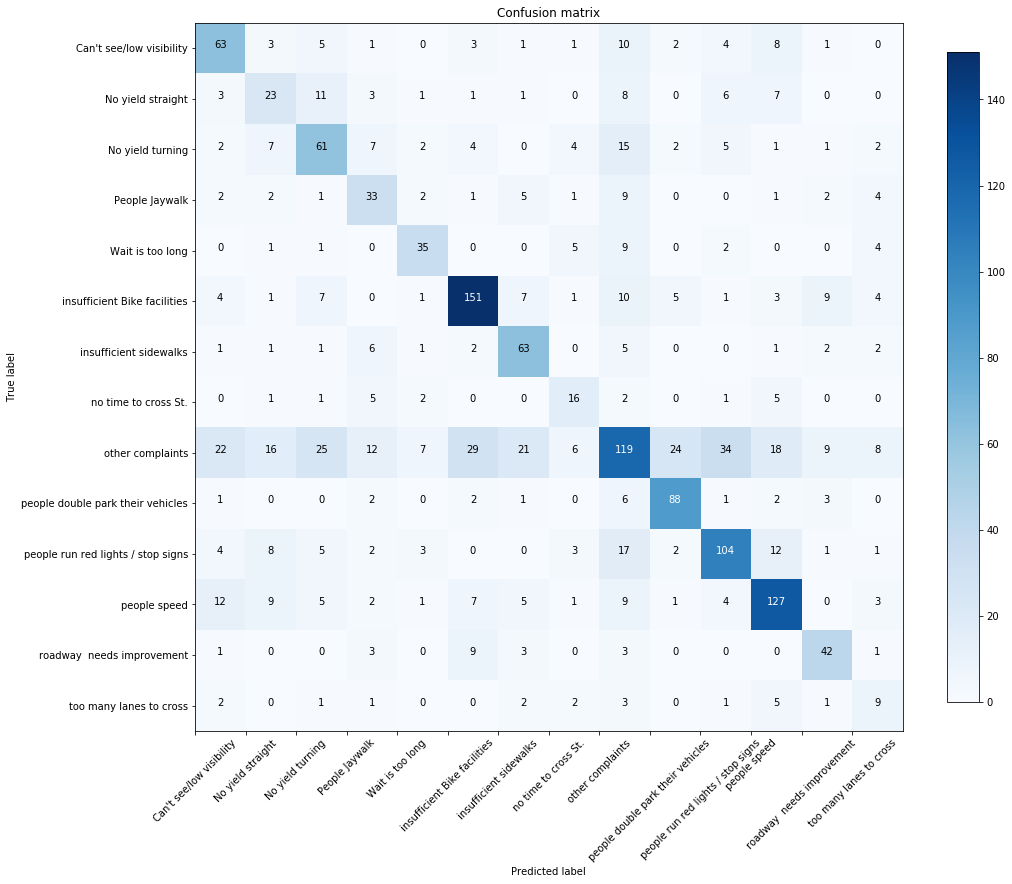

In [14]:

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    #Source:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks-0.5, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.colorbar(shrink = 0.65)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


ypred = model1_pipe.fit(X_train,y_train).predict(X_test)
cmf_matrix = confusion_matrix(y_test,ypred)
np.set_printoptions(precision=2)


class_names = np.unique(y_test.values)

plt.figure(figsize=(15,15))
plot_confusion_matrix(cmf_matrix, classes=class_names,
                      title='Confusion matrix')

plt.show()

# Task3 - Model 2 [30 points]

Improve the model using more complex text features, including n-grams, character n-grams and possibly domain-specific features.

In [17]:
X_train, X_test, y_train, y_test = generate_train_test('Vision_Zero_Entry.csv')

"""
model2_pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,7),analyzer = 'char',stop_words='english'), 
            LogisticRegression(C=10,class_weight='balanced', multi_class='multinomial',solver='sag'))


0.5796

scores :  [ 0.56  0.55  0.54]
mean :  0.548597640962

"""



model3_pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,2),min_df=1,max_df=1.0,stop_words='english'),
            LogisticRegressionCV(Cs=20,class_weight='balanced', multi_class='multinomial',solver='sag',cv=3))






combined_features=FeatureUnion([("ngram", TfidfVectorizer(ngram_range=(1,2))),\
                            ('char', TfidfVectorizer(ngram_range=(1,7),analyzer = 'char'))])

model2_pipe = make_pipeline(combined_features, 
            LogisticRegression(C=20,class_weight='balanced', multi_class='multinomial',solver='sag'))



In [18]:
"""
combined_features=FeatureUnion([("ngram", TfidfVectorizer(ngram_range=(1,2))),('char',\
                                                TfidfVectorizer(ngram_range=(1,2),analyzer = 'char'))])

model2_pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,2),analyzer = 'char'),MaxAbsScaler(),TruncatedSVD(n_components=100),

            LogisticRegressionCV(Cs=100,class_weight='balanced', multi_class='multinomial',solver='sag',cv=3))

""" 

'\ncombined_features=FeatureUnion([("ngram", TfidfVectorizer(ngram_range=(1,2))),(\'char\',                                                TfidfVectorizer(ngram_range=(1,2),analyzer = \'char\'))])\n\nmodel2_pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,2),analyzer = \'char\'),MaxAbsScaler(),TruncatedSVD(n_components=100),\n\n            LogisticRegressionCV(Cs=100,class_weight=\'balanced\', multi_class=\'multinomial\',solver=\'sag\',cv=3))\n\n'

In [19]:
"""
model2_pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,9),analyzer = 'char'), 
            LogisticRegression(C=25,class_weight='balanced', multi_class='multinomial',solver='sag'))
"""

"\nmodel2_pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,9),analyzer = 'char'), \n            LogisticRegression(C=25,class_weight='balanced', multi_class='multinomial',solver='sag'))\n"

In [20]:
#cv_score(model2_pipe,X_train,y_train,cv=3)


In [21]:
model2_pipe.fit(X_train,y_train)

Pipeline(steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('ngram', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ...l2',
          random_state=None, solver='sag', tol=0.0001, verbose=0,
          warm_start=False))])

In [22]:
assert f1(model2_pipe,X_test,y_test) > 0.57

# Task4 - Visualize Results [10 points]

Visualize results of the tuned model (classification results, confusion matrix, important features, example mistakes).

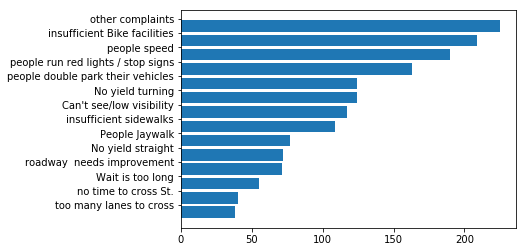

In [23]:

array =zip(np.unique(ypred,return_counts=1)[0],np.unique(ypred,return_counts=1)[1])
sortedlabel = sorted(array,key=itemgetter(1))

label,count = zip(*sortedlabel)
plt.barh(np.arange(len(label)),count)
plt.yticks(np.arange(len(label))+0.5,label)
plt.show()

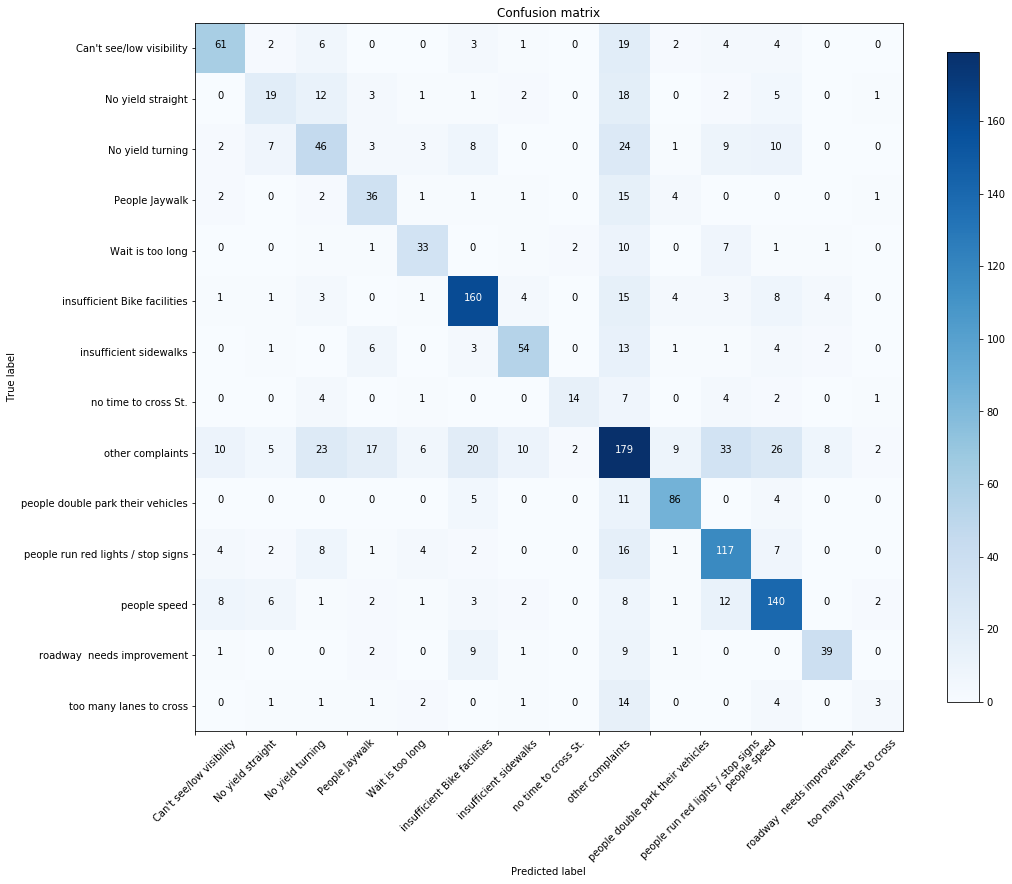

In [24]:
# Add your code for task 4 here. You may use multiple cells. 
ypred2 = model2_pipe.predict(X_test)

cmf_matrix = confusion_matrix(y_test,ypred2)
np.set_printoptions(precision=2)


class_names = np.unique(y_test.values)

plt.figure(figsize=(15,15))
plot_confusion_matrix(cmf_matrix, classes=class_names,
                      title='Confusion matrix')

plt.show()


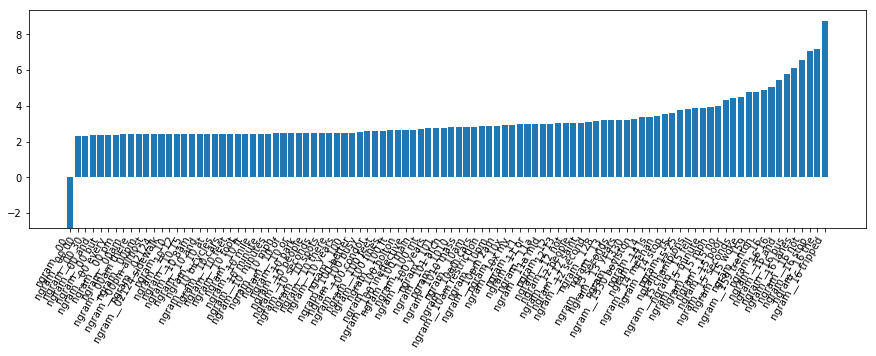

In [25]:
feature_names = model2_pipe.named_steps["featureunion"].get_feature_names()

def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    myrange = range(len(inds))
    combined_inds = inds[sort_sign]

    ax.bar(myrange, coef[combined_inds])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names, rotation=60, ha="right")
    
plt.figure(figsize=(15, 4))
plot_important_features(model2_pipe.named_steps["logisticregression"].coef_.ravel(),\
                        np.array(feature_names), top_n=100)

plt.show()

In [26]:
# 10 EAXMPLES WHERE PREDICTION WAS WRONG
i=0
for comment in X_test[y_test[y_test!=ypred2].index].values:
    i+=1
    print 'INSTANCE' + str(i) + '- '+ comment
    if i == 10:
        break

INSTANCE1- this intersection is designed for drivers -- it disregards walker and biker safety. It's terrible.  There is no way any planner or engineer involved actually regularly walks or bikes, or they would not let the intersection remain this way.
INSTANCE2- There are no traffic controls at this intersection, making it a free-for-all. Two roads coming eastbound, one south, one west, all converging with no clear markings and few people ever stopping.
INSTANCE3- There is so much wrong with this intersection. Double parking, not yielding when going straight, not yielding when turning, low visibility, people run red lights, etc.
INSTANCE4- Drivers speed to get through town and frequently don't see or yield for pedestrians
INSTANCE5- People don't shovel their sidewalks going to the bus stops or the central business district.   They get violations from the city and still do nothing.  The city should plow the sidewalks on main thoroughfare sidewalks in JP and in other areas.
INSTANCE6- Ver

# Task5 - Clustering [10 points]

Apply LDA, NMF and K-Means to the whole dataset. Can you find clusters or topics that match well with some of the ground truth labels? Use ARI to compare the methods and visualize topics and clusters.

In [27]:
foo = import_data('Vision_Zero_Entry.csv')
bar = clean_labels(foo)
y_train= bar['REQUESTTYPE']
X_train = bar['COMMENTS']

In [28]:


def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    myrange = range(len(inds))
    combined_inds = inds[sort_sign]

    ax.bar(myrange, coef[combined_inds])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[combined_inds], rotation=60, ha="right")
    

In [29]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [30]:
vect = CountVectorizer(ngram_range=(1,2),stop_words='english')

X_vect = vect.fit_transform(bar['COMMENTS']) 

X_scaled = MaxAbsScaler().fit_transform(X_vect)

nmf_scale = NMF(n_components=20, tol=0.01)

nmf_scale.fit(X_scaled)

X_nmf_scale = nmf_scale.transform(X_scaled)





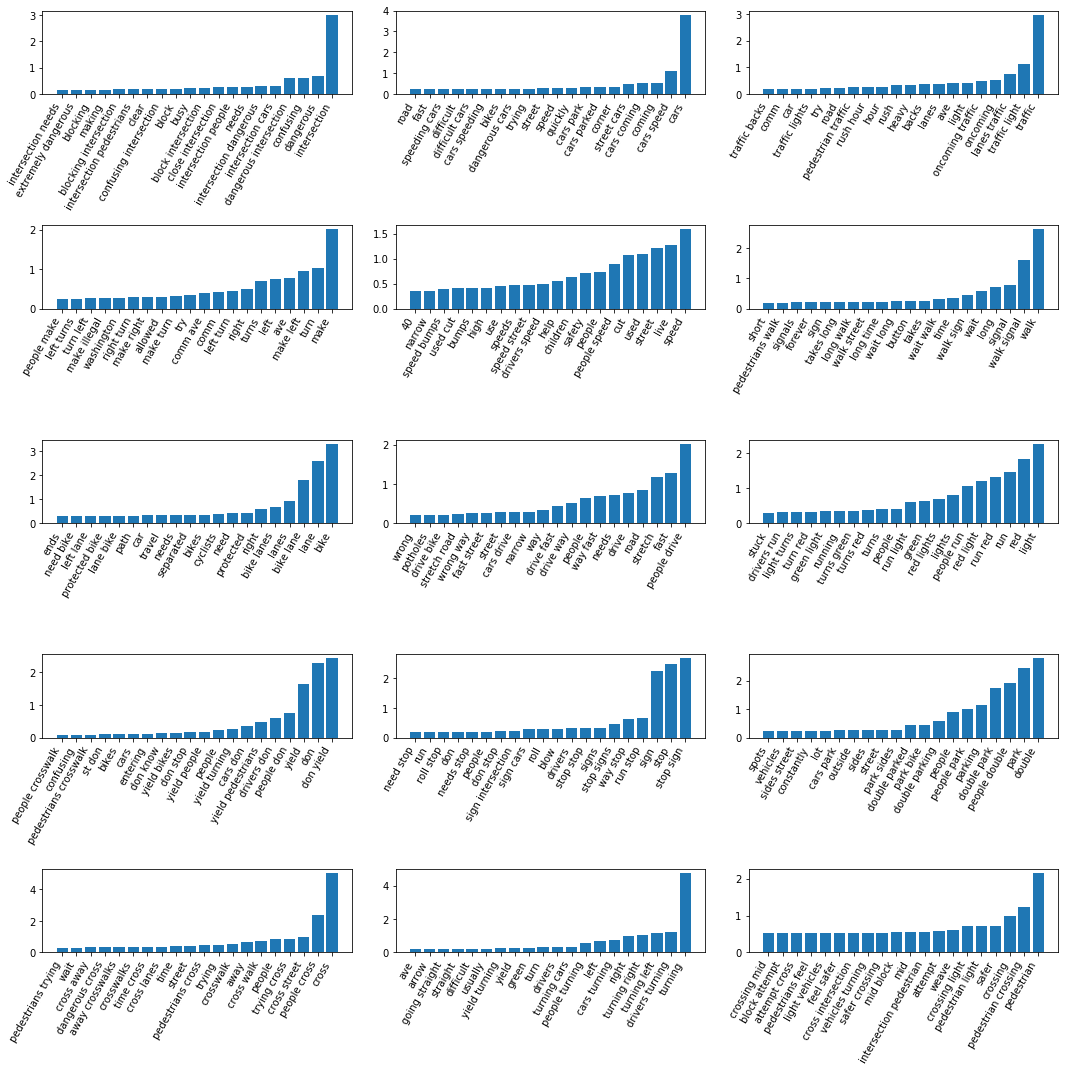

In [31]:
large_comp_inds = np.argsort(X_nmf_scale.mean(axis=0))[-15:][::-1]

feature_names = np.array(vect.get_feature_names())
n_components = 15
fig, axes = plt.subplots(5, 3, figsize=(15, 15))
for ax, coef in zip(axes.ravel(), nmf_scale.components_[large_comp_inds, :]):
    plot_important_features(coef, feature_names, top_n=20, ax=ax)
    
plt.tight_layout()
plt.show()

In [32]:
print_top_words(nmf_scale,vect.get_feature_names(),20)

Topic #0:
pedestrians pedestrians crossing yield yield pedestrians drivers crosswalk stop pedestrians crossing pedestrians crosswalk dangerous pedestrians drivers yield fail dangerous drivers turning pedestrians cross fail yield crossing street pedestrians crosswalks drivers pedestrians pedestrians drivers
Topic #1:
bike lane bike lane lanes bike lanes right protected need cyclists bikes separated needs travel car path lane bike protected bike left lane need bike ends
Topic #2:
don yield don yield people don drivers don yield pedestrians cars don yield turning people yield people don stop yield bikes don know entering cars bikes st don pedestrians crosswalk confusing people crosswalk
Topic #3:
speed live street used cut people speed people safety children help drivers speed speed street speeds use high bumps used cut speed bumps narrow 40
Topic #4:
cross people cross cross street trying cross people cross walk away crosswalk trying pedestrians cross street time cross lanes time cross c

Much of the old categories are distinguishable from the topics as well as the clusters. 

In [33]:
vect2 = CountVectorizer(stop_words='english')
X_vect2 = vect2.fit_transform(bar['COMMENTS']) 


lda = LatentDirichletAllocation(n_topics=12, learning_method="batch")
X_lda = lda.fit_transform(X_vect2)

lda.fit(X_vect2)



LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_jobs=1, n_topics=12, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

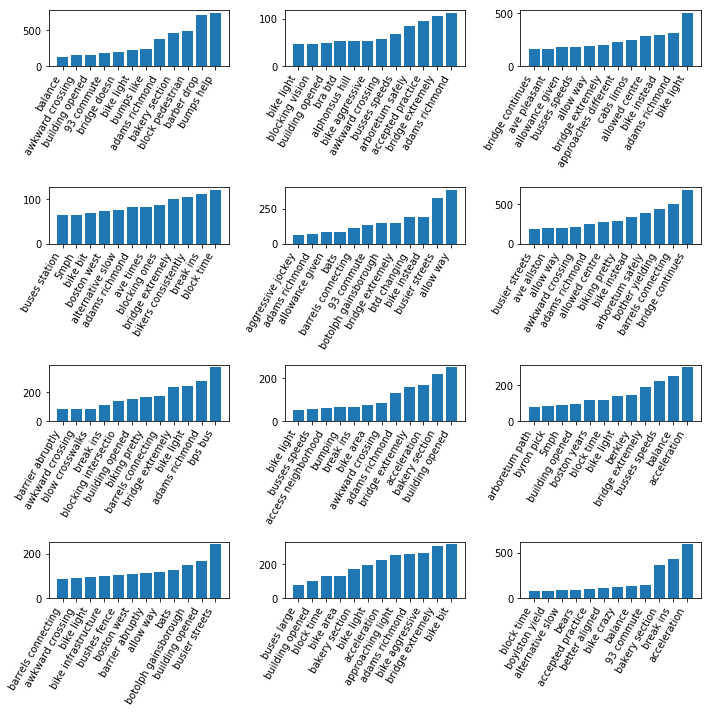

In [34]:
feature_names = np.array(vect.get_feature_names())
fig, axes = plt.subplots(4, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), lda.components_):
    plot_important_features(coef, feature_names, top_n=12, ax=ax)

plt.tight_layout()
plt.show()

In [35]:
print_top_words(lda,vect.get_feature_names(),20)

Topic #0:
bumps help barber drop block pedestrian bakery section adams richmond bumps like bike light bridge doesn 93 commute building opened awkward crossing balance arboretum safely automatically cycle beacon corner bumps needed bike aggressive aggressive intersection alternative slow aggressive jockey
Topic #1:
adams richmond bridge extremely accepted practice arboretum safely busses speeds awkward crossing bike aggressive alphonsus hill bra btd building opened blocking vision bike light alternative slow acceleration actions button flash built access neighborhood beacon crosswalk bikers away
Topic #2:
bike light adams richmond bike instead allowed centre cabs limos approaches different bridge extremely allow way busses speeds allowance given ave pleasant bridge continues arboretum safely arboretum path awkward crossing arrow washington block pedestrian bumps like break ins alternative slow
Topic #3:
block time break ins bikers consistently bridge extremely blocking ones ave times ad

In [36]:
#K MEANS
Kmeans = KMeans(n_clusters=14, random_state=0).fit(X_vect)


In [84]:
A = Kmeans.labels_
plt.scatter( A[np.where(A==1)])
"""
np.where(A==2)
np.where(A==3)
np.where(A==4)
np.where(A==5)
np.where(A==6)
np.where(A==7)
np.where(A==8)
np.where(A==9)
np.where(A==10)
np.where(A==11)
np.where(A==12)
np.where(A==13)
"""
plt.show()

TypeError: scatter() takes at least 2 arguments (1 given)

In [87]:
bar[np.where(A==1)]


TypeError: unhashable type: 'numpy.ndarray'

In [38]:
# ARI FOR K MEANS

adjusted_rand_score(bar['REQUESTTYPE'],Kmeans.labels_)

0.041518394118101855

In [39]:
# ARI FOR LDA

adjusted_rand_score(bar['REQUESTTYPE'],np.argmax(X_lda,axis=1))


0.10156820087811513

In [40]:
# ARI FOR NMF

adjusted_rand_score(bar['REQUESTTYPE'],np.argmax(X_nmf_scale,axis=1))

0.098395681872004023

In [41]:
# ARI BETWEEN K MEANS AND NMF
adjusted_rand_score(Kmeans.labels_,np.argmax(X_nmf_scale,axis=1))

0.13471161774630741

# Task6 - Model 3 [30 points]

Improve the class definition for REQUESTTYPE by using the results of the clustering and results of the previous classification model. Re-assign labels using either the results of clustering or using keywords that you found during data exploration. The labels must be semantically meaningful.
The data has a large “other” category. Apply the topic modeling and clustering techniques to this subset of the data to find possible splits of this class.
Report accuracy using macro average f1 score (should be above .53) 


In [42]:
# This is my relabeling using LDA 
foo = import_data('Vision_Zero_Entry.csv')
bar = clean_labels(foo)

LDA_y = np.argmax(X_lda,axis=1)

X_LDA_train, X_LDA_test, y_LDA_train, y_LDA_test = train_test_split( bar['COMMENTS'], LDA_y,\
                                                    random_state = 1992, stratify = LDA_y )
model1_pipe.fit(X_LDA_train,y_LDA_train)


Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,...    random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0))])

In [43]:
assert f1(model1_pipe,X_LDA_test,y_LDA_test) > 0.61

In [44]:
#RELABELING USING NMF AND N_GRAM = 2
# THIS MADE MOST SEMANTIC SENSE WHILE HAVING A REALLY GOOD SCORE SO WOULD BE MY FINAL CHOICE
NMF_y = np.argmax(X_nmf_scale,axis=1)

X_NMF_train, X_NMF_test, y_NMF_train, y_NMF_test = train_test_split( bar['COMMENTS'], NMF_y,\
                                                    random_state = 1992, stratify = NMF_y )
model1_pipe.fit(X_NMF_train,y_NMF_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,...    random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0))])

In [45]:
assert f1(model1_pipe,X_NMF_test,y_NMF_test) > 0.75

Comments can be categorized as "comments regarding:  Bike Lanes, Cars not following traffic rules, Pedestrians not following traffic rules, Cars' erroneous turns, inadequate traffic signs, parking, speeding, crowd control, infrastructure, unneccessary traffic rules, not adequate traffic rules and other.

In [46]:
#OTHER SECTION ANALYSIS
OTHERCOMMENTS = bar[bar['REQUESTTYPE']=='other complaints']['COMMENTS']

vect3 = CountVectorizer(stop_words='english')
X_vect3 = vect3.fit_transform(OTHERCOMMENTS) 


ldav3 = LatentDirichletAllocation(n_topics=12, learning_method="batch")
X_lda = lda.fit_transform(X_vect3)

ldav3.fit(X_vect3)




LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_jobs=1, n_topics=12, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [47]:
print_top_words(ldav3,vect.get_feature_names(),20)

Topic #0:
amory 555 anderson avoid traffic atrocious cars amory approaching ave needs actual marked 90 looking area speeding approach high average speed 39 appreciate 45 degrees 300 accident waiting avoid washington 15 aggressivley allows fast
Topic #1:
average speed area speeding attention intersection ave nice allandale supposed accidents daily actual 90 looking attacking cyclists amory approaching actual marked ave makes 8th compacted arborway pedestrians 45 degrees 70 way backing traveling ave andrew baby carriage access pond
Topic #2:
area speeding 45 degrees ave going ave adams amory approaching average speed atleast 90 actual 45am 300 30am 45 amory 555 arborway pedestrians avoid area ave entering amory centre activates arborway proceed area mess angle safety
Topic #3:
ave nice area mess area near 90 looking area speeding 70 way arboretum sidewalks ave according ave makes 74 attacking cyclists backing traveling accommodation people activates area moms actual marked audio 8th comp

In [48]:
vect4 = CountVectorizer(ngram_range=(1,2),stop_words='english')

X_vect4 = vect4.fit_transform(OTHERCOMMENTS) 

X_scaled4 = MaxAbsScaler().fit_transform(X_vect4)

nmf_scale4 = NMF(n_components=20, tol=0.01)

nmf_scale4.fit(X_scaled4)

X_nmf_scale4 = nmf_scale4.transform(X_scaled4)




In [49]:
print_top_words(nmf_scale4,vect.get_feature_names(),20)

Topic #0:
arrows folks atrocious spots ashford st corner faced emergency vehicle corner floods enable don follow don pedestrians currently just drivers look assist stage centre blind edge quite avet crashes flashing especially columbus asticou needs atrocious direct crosswalk
Topic #1:
begins curve covered dirt crab consider cyclists turn bridge proper entirely belgrade straight accidents speed cyclists unsafe cars slope cram intersection bridge repair exiting bunker bedford st crazy potholes entrance public commonwealth switching entrance reservoir detailing numerous clear busy
Topic #2:
center roche chip away currently just children hospital egregious coming melbourne character doing roadwork 30 sec ahead curve time don check advertisement sign communities eliminated community college changes realize cone sign declared church
Topic #3:
buses poplar city cars crosswalk traffic buses livery collision directly drawn painted encroach clear actually crosswalk visibility dresden spring ent

The two topics listed avove provide enough context to realize that the other comments can first of all be separated as those concerning bicycles and those which do not. Another distinction can be made about crosswalks, morning traffic, other time traffic, those concerning crime, those concerning potential hazards, and those concerning personal complaints or complaints about persons,

# Extra Credit [Up to +20 points]

Use a word embedding representation like word2vec for step 3 and or step 6. 

In [50]:
# Add your code for extra credit here. You may use multiple cells. 
foo = import_data('Vision_Zero_Entry.csv')
bar = clean_labels(foo)

model = models.Word2Vec([i for i in bar['COMMENTS']], min_count=1)

In [51]:
X_train, X_test, y_train, y_test = generate_train_test('Vision_Zero_Entry.csv')

In [52]:
def read_corpus(text, tokens_only=False):
    for i, line in enumerate(text):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])

In [59]:
train_corpus = list(read_corpus(X_train))
test_corpus = list(read_corpus(X_test,tokens_only=True))

In [71]:
model = gensim.models.doc2vec.Doc2Vec(size=600,iter=55)
model.build_vocab(train_corpus)

In [72]:
model.train(train_corpus, total_examples=model.corpus_count)

4727580

In [73]:
vectors = [model.infer_vector(train_corpus[doc_id].words)
          for doc_id in range(len(train_corpus))]
X_train = np.vstack(vectors)

In [74]:
test_vectors = [model.infer_vector(test_corpus[doc_id])
                for doc_id in range(len(test_corpus))]
X_val = np.vstack(test_vectors)

In [75]:
model2_pipe.named_steps["logisticregression"].fit(X_train,y_train)
prediction2 = model2_pipe.named_steps["logisticregression"].predict(X_val)

In [70]:
# PREDICTION FOR TASK 3
#model1_pipe.named_steps["logisticregression"].fit(X_train,y_train)
#prediction1 = model2_pipe.named_steps["logisticregression"].predict(X_val)